In [308]:
from __future__ import absolute_import, print_function, unicode_literals
import sys
import os
import repackage
repackage.up()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import analysis2 as a2
reload(a2)
from IPython.display import display, HTML
sys.path.append('/home/janekg89/Develop/Pycharm_Projects/flutype_webapp')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "flutype_webapp.settings")
import django
django.setup()
from flutype.models import Spot

In [309]:
cs = ["slide_21","slide_22","slide_26","slide_27","slide_31","slide_32","slide_36","slide_23","slide_28","slide_33","slide_37"]
spots_dj = Spot.objects.filter(raw_spot__raw_spot_collection__sid__in=cs)
#spots_dj = spots_dj.filter(raw_spot__lig_fix_batch__sid__in = lb)
spots_dj = spots_dj.filter(spot_collection__sid = "quant1")
spots_dj = spots_dj.filter(circle_quality__gte = 0.3)

In [310]:
data = a2.Data(spots_dj=spots_dj).outlier_filtering().sample_on_collection(20).clean()
lb = data.ligand_batch_significance().groupby("Ligand Batch").apply(lambda x: x["Significance"].max()).sort_values(ascending=False)
pbs = [list(lb.index.values[:i]) for i in range(1,len(lb.index.values))]
pb = pbs[25]


In [311]:
spots_this = spots_dj.filter(raw_spot__lig_fix_batch__sid__in = pb)
data = a2.Data(spots_dj=spots_this)
data = data.outlier_filtering().sample_on_collection(200).clean().reset_index()

In [312]:
data.train_test_combinations
from sklearn.model_selection import GroupKFold,LeavePGroupsOut, GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import validation_curve, learning_curve, cross_val_score

from sklearn.linear_model import LogisticRegression


In [313]:
#g = GroupShuffleSplit(test_size=0.33,n_splits=30)
#label_collection = LabelEncoder()
#label_y = LabelEncoder()
x = data.x
#y = label_y.fit_transform(data.y_names)
y= data.y_names
#groups = data.x.index.get_level_values("Collection")
#a = g.split(x,y,groups)




In [343]:
co= data.x.reset_index()["Collection"]
all_d = [(np.array(co.index),np.array(co.index))]

In [337]:
def collections_to_index(cs):
    co = data.x.reset_index()["Collection"]
    return np.array(co.index[co.isin(cs)])


cvs = data.train_test_combinations[["Train","Test"]]
#cv = data.combination_split_train_test().applymap(collections_to_index).values
cvs = cvs.applymap(collections_to_index).values
cv = [tuple(t) for t in cvs]

In [240]:
#data = a2.Data(spots_pd=data.spots_pd.reset_index())
#test_set = data.subset_collection(cn)

In [316]:
# = LogisticRegression(random_state=0, penalty="l2")
lg_norm = LogisticRegression(multi_class ="multinomial",solver='lbfgs')

In [255]:
param_range = [0.001,0.01,0.1,1.0,10.0,100.0]
training_scores, test_scores = validation_curve(estimator=lg, X=x,y=y,param_name="C", param_range=param_range,groups=y, cv=cv)

In [260]:
training_scores.shape
test_scores.shape

(6, 54)

In [256]:
train_mean = np.mean(training_scores,axis=1)
train_std = np.std(training_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)


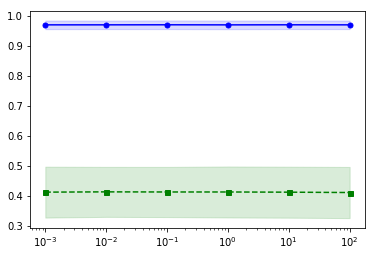

In [257]:
plt.plot(param_range,train_mean,color="blue",marker="o", markersize=5,label="training accuracy")
plt.fill_between(param_range,train_mean+train_std,train_mean-train_std,alpha=0.15,color="blue")
plt.plot(param_range,test_mean,color="green",marker="s", markersize=5, linestyle="--",label="test accuracy")
plt.fill_between(param_range,test_mean+test_std,test_mean-test_std,alpha=0.15,color="green")

plt.xscale("log")
#plt.yscale("log")

plt.show()

In [344]:
x = data.x
y= data.y_names
scor = cross_val_score(estimator=lg_norm, X=x,y=y,cv=all_d)

In [345]:
scor.mean()

0.93000000000000005

In [346]:
complete = data.train_test_combinations[:1]
complete["Test"]=[tuple(cs)]*len(complete)
complete["Train"]=[tuple(cs)]*len(complete)
complete.loc[1] = complete.loc[0]

/home/janekg89/Envs/flutype_webapp/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/janekg89/Envs/flutype_webapp/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/janekg89/Envs/flutype_webapp/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats i

In [347]:
x = data.x
ana = a2.Analysis(data,train_test=complete)

In [348]:
ana.calculate_all()

*****LogisticRegression*****
*****Fit Models*****
*****Predict*****


array([u'A/Brisbaine/59/2007(H1N1)-2018-03-20',
       u'A/Brisbane/10/2007(H3N2)-2017-07-05',
       u'A/California/7/2009(H1N1)-2018-03-20',
       u'A/Hong Kong/4801/2014(H3N2)-2018-03-20'], dtype=object)

In [328]:
#ana.result
43200/200/54

4

In [349]:
ana.complete_information()["TrueFalse"].mean()

0.93000000000000005

In [289]:
x.iloc[cv[0,1]].index.get_level_values("Collection").unique()

Index([u'slide_26', u'slide_36', u'slide_31', u'slide_21'], dtype='object', name=u'Collection')

In [284]:
cv[0,0]

array([ 200,  201,  202, ..., 2197, 2198, 2199])